In [501]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels as sm
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA_new
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

# Time Series modelling

Time domain vs Frequency domain

- Time domain aprroach: forecasting future data using past data, uses lagged relationships as important (Autocorrelation)
- Frequency domain approach: uses cycles or seasonality(?) relationships (Spectral analysis, wavelet analysis)

## Approach

1. Define the problem
2. Collect the data
    - Data should be relevant - should relate to the problem
    - Accurate - Accurate in terms of timestamps of observation
    - Long enough - Enough to forecast to capture all patterns
3. Analyse the data to identify patterns
    - Components of time series to be considered
        - Level: Average value of the series(?)
        - Trend: Long term progression of the series. Persistent increase or decrease in data. The tendency of the data to increase, decrease or stagnate over long periods of time.
        - Seasonality: Seasonal or Periodic repetition of the data. 
        - Cyclicity: Non periodic repetition of the data
        - Noise: Random irregular influence on the data
4. Build and evaluate forecast patterns

## Collecting data

1. Data can come from a repository that is public or private sources
2. Data can also be streamed continously from a sensor (telemetry data)

**Sources**

1. https://machinelearningmastery.com/time-series-datasets-for-machine-learning/


In [502]:
#Data from https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
#df_original = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df_original = pd.read_csv('airline-passenger-traffic.csv', header = None)
print(df_original.shape)
df_original.head()

(144, 2)


,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [503]:
ts = 'Date'
y = 'Passengers'
df_original.columns = [ts, y]
#Set the timestamps as the index of the data frame
df_original = df_original.set_index(keys=ts, drop=True)
df_original.index = pd.to_datetime(df_original.index, format="%Y-%m")
df = df_original.copy()

In [504]:
df.head()

,Passengers
Date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


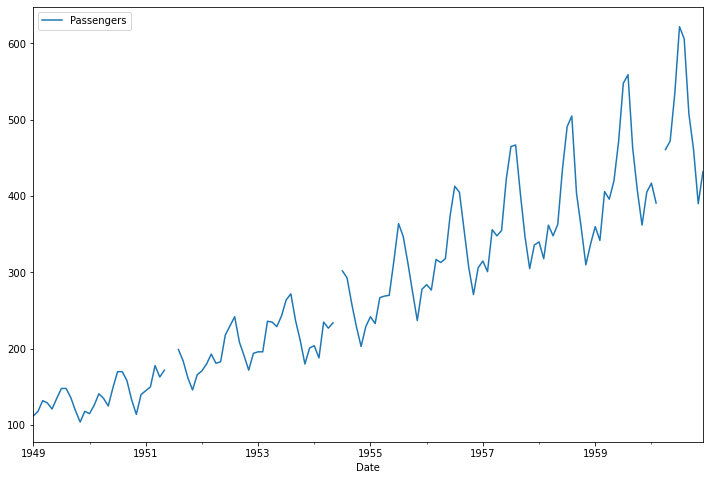

In [505]:
df.plot()
plt.show()

**Handling missing data**

In [506]:
#Data has missing values
#Otherwise we can randomly mark values as Nan for study
#Use numpy's random.choice to select 10% of indices for nans
#random_idx = np.random.choice(df.shape[0], size=int(df.shape[0]*0.1))
#df.iloc[random_idx] = np.nan

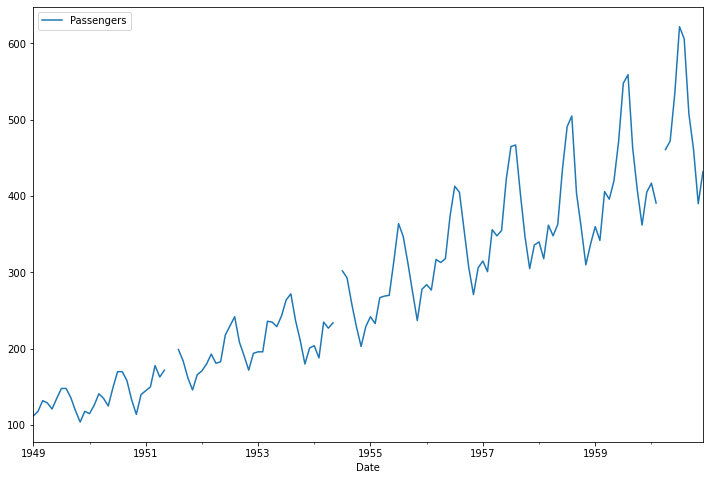

In [507]:
df.plot()
plt.show()

**Imputing with mean**

Mean: 280.73571428571427


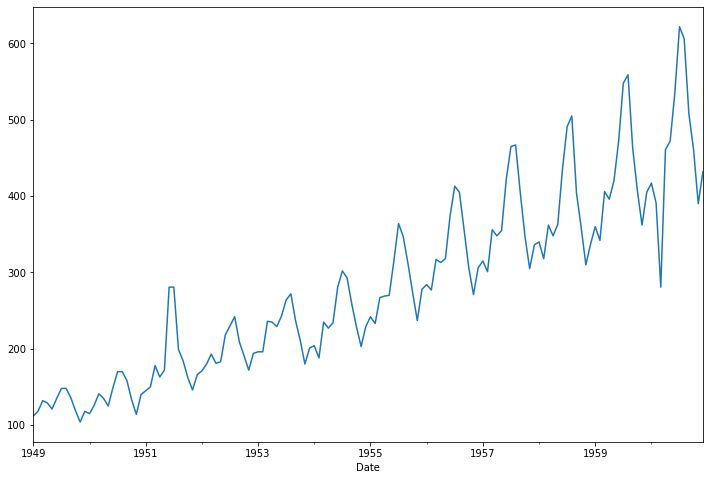

In [508]:
mean=df[y].mean()
print("Mean: {}".format(mean))
df[y + '_mean_imputed'] = df[y].fillna(mean)
df[y + '_mean_imputed'].plot()
plt.show()

**Imputing with last observation**

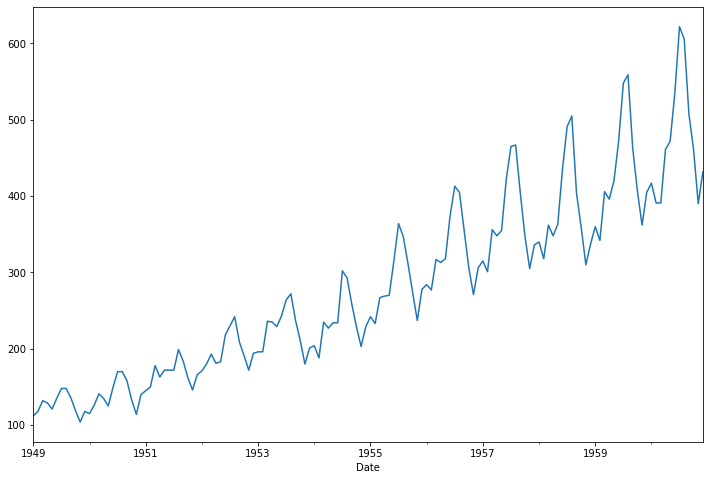

In [509]:
df[y+'_last_obs_imputed'] = df[y].fillna(method='ffill')
df[y+'_last_obs_imputed'].plot()
plt.show()

**Imputing with linear interpolation**

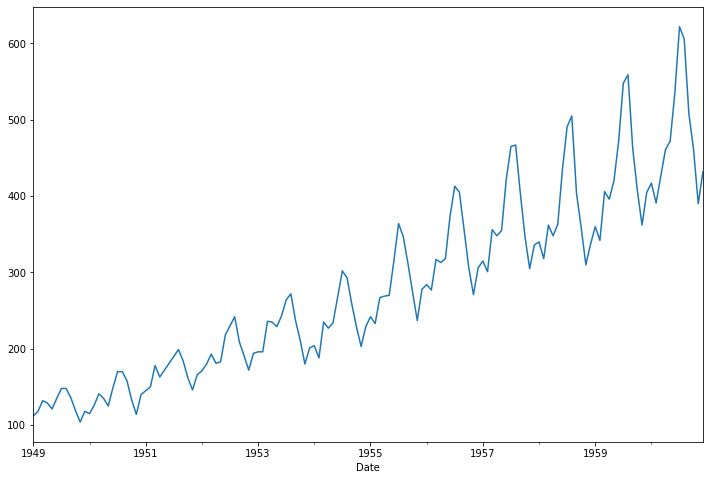

In [510]:
df[y+'_linear_interpolation'] = df[y].interpolate(method='linear')
df[y+'_linear_interpolation'].plot()
plt.show()

**Imputing with linear interpolation with seasonal info**

**Choose one and complete the imputation**

In [511]:
#Get the original dataset (If the original dataset had missing values, we should consider data after the missing values were handled)
#df = df_original.copy()
df_ml = df[[y+'_linear_interpolation']].copy()
df_ml.columns = [y]

## EDA on the data

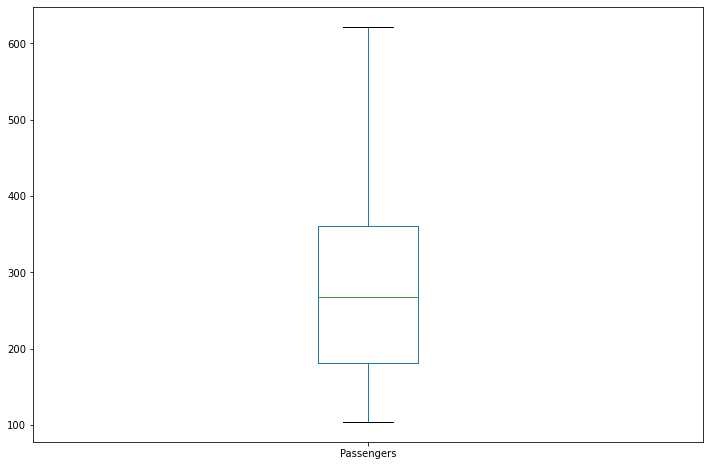

In [512]:
#Not seeing any outliers
df_ml[y].plot(kind='box')
plt.show()

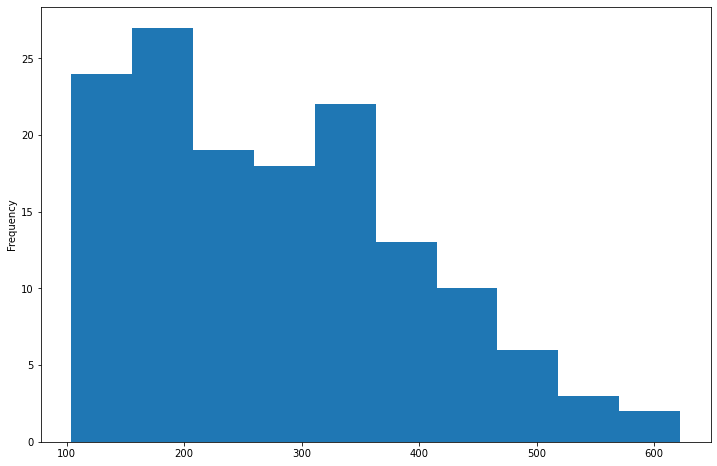

In [513]:
#Distribution of data shows that a lot of the times passengers are within 150-300
df_ml[y].plot(kind='hist')
plt.show()

**Time series graph**

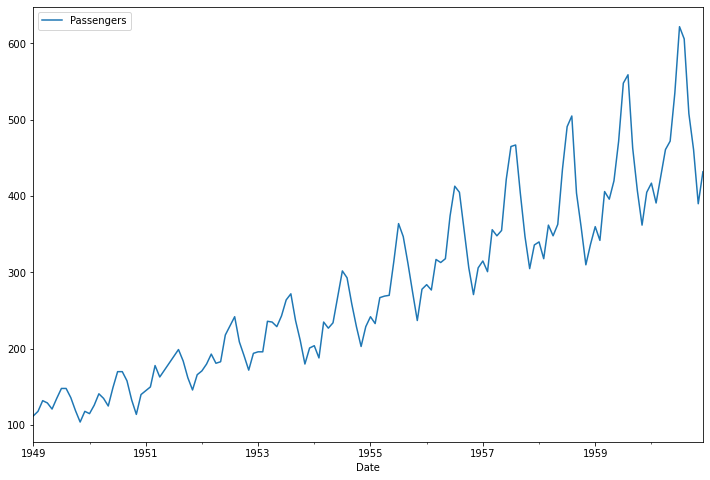

In [514]:
df_ml.plot()
plt.show()

1. We can see that the amplitude of the cycles is increasing over time.
2. There looks to be a linear trend with peaks and the troughs of the dataset increasing over time


### Decomposition into components

Time series has 4 components
1. Level
2. Trend
3. Seasonality
4. Residual

For additive models, the time series is realised as

    `y = Level + Trend + Seasonality + Residual`
    
   - Linear relationship with result
   - The amplitude of the peaks do not change much over time
    
For multiplicative models, the time series is realised as

    `y = Level * Trend * Seasonality * Residual`
    
   - Non linear relationship with result
   - Noticeable change in amplitude peaks over time

**Visualsing the breakdown of the time series graph (Additive decomposition)**

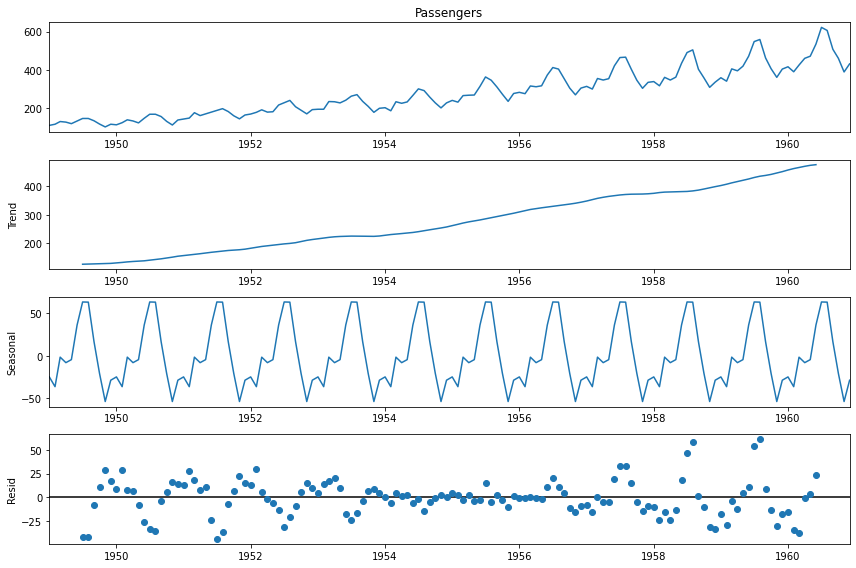

In [515]:
decomposition_add = tsa.seasonal_decompose(df_ml[y], model='additive')
decomposition_add.plot()
plt.show()

**Visualsing the breakdown of the time series graph (Multiplicative decomposition)**

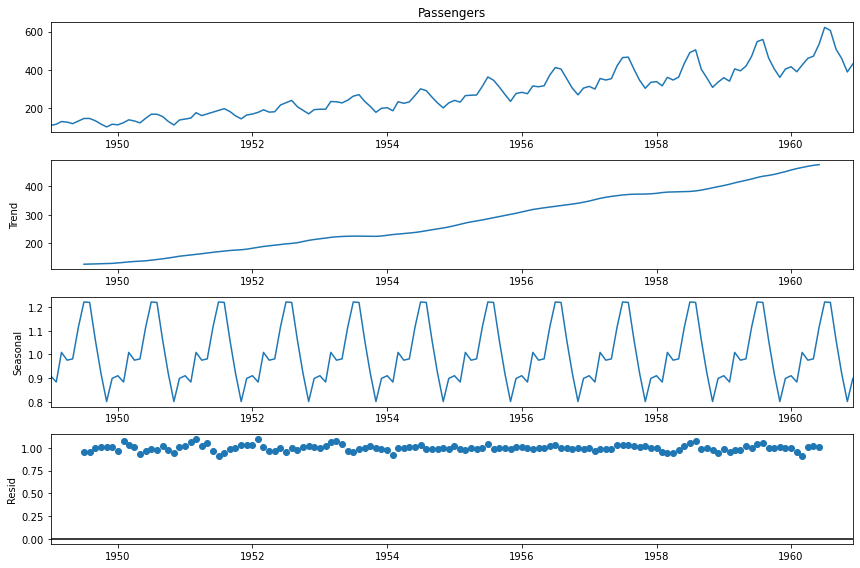

In [516]:
decomposition_mul = tsa.seasonal_decompose(df_ml[y], model='multiplicative')
decomposition_mul.plot()
plt.show()

**Comparing additive and multiplicative decompositions**

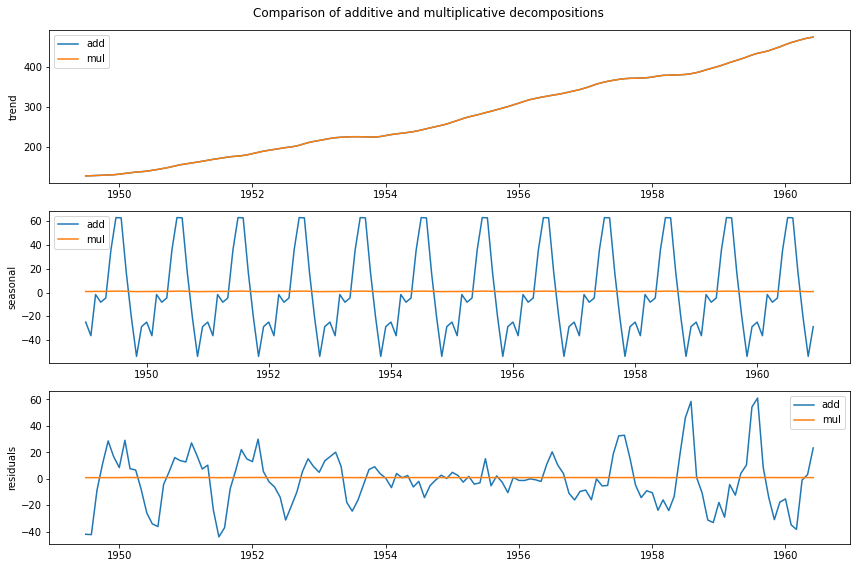

In [517]:
fig, axs = plt.subplots(nrows=3)
axs[0].plot(decomposition_add.trend, label='add')
axs[0].plot(decomposition_mul.trend, label='mul')
axs[0].legend()
axs[0].set_ylabel('trend')
axs[1].plot(decomposition_add.seasonal, label='add')
axs[1].plot(decomposition_mul.seasonal, label='mul')
axs[1].legend()
axs[1].set_ylabel('seasonal')
axs[2].plot(decomposition_add.resid, label='add')
axs[2].plot(decomposition_mul.resid, label='mul')
axs[2].legend()
axs[2].set_ylabel('residuals')
plt.suptitle("Comparison of additive and multiplicative decompositions")
fig.tight_layout()
plt.show()

## Setting up for models

- In regular ML modelling we would get our training data by creating a collection of iid (independent and identically distributed random data).
- But the same can't be performed for TimeSeries data as we are forecasting future data from the past, so our training data has to be the past and our test data the future

In [518]:
train_share = 0.8
#train_test_split_index = int(df_ml.shape[0]*0.8)
train_test_split_index = 120
df_train = df_ml[:train_test_split_index]
df_test = df_ml[train_test_split_index:]
#We will create a df_predictions to store our predictions to compare with the test
df_pred = df_test.copy()
df_pred.columns = ['Expected']
print("Training data shape: {}".format(df_train.shape))
print("Test data shape: {}".format(df_test.shape))

Training data shape: (120, 1)
Test data shape: (24, 1)


`Questions`
1. Is the choice of % split good? Or should the splitting be done at a peak or trough? Or at intervals

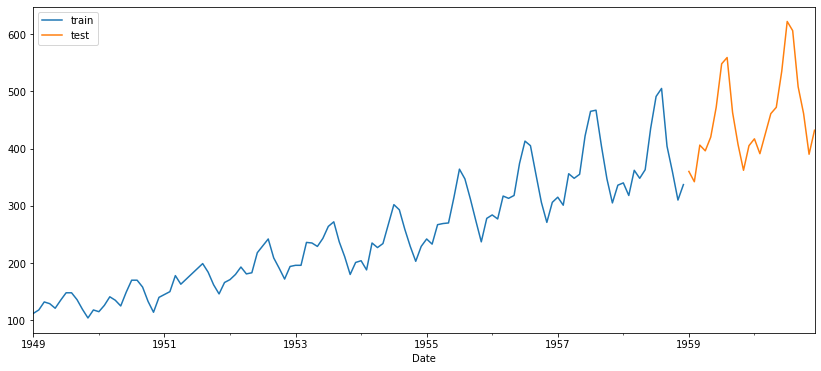

In [519]:
##Visualsing the splits of training and testing
fig, ax = plt.subplots(figsize=(14,6))
df_train[y].plot(ax=ax, label='train')
df_test[y].plot(ax=ax, label='test')
plt.legend()
plt.show()

## Performance measurement criteria

1. Mean Error (shows how the models is biased, is it over predicting or under predicting)
2. Mean Absolute Error (MAE) (Independent of direction of prediction) 
3. Mean of percent of absolute error (MAPE)
4. Mean of squared error (MSE)
5. Root of mean of squared error (RMSE)

**MAPE**

In [520]:
def get_mape(y_true, y_pred):
    err = y_true - y_pred
    abs_err = abs(err)
    #Need to handle divide by 0 error
    pct_abs_err = 100*abs(err)/y_true
    mape = np.mean(pct_abs_err)
    return round(mape, 2)

**RMSE**

In [521]:
def get_rmse(y_true, y_pred):
    err = y_true - y_pred
    sq_err = np.square(err)
    mean_sq_err = np.mean(sq_err)
    rmse = np.sqrt(mean_sq_err)
    return round(rmse, 2)

In [522]:
def evaluate_perf(y_true, y_pred, model='Model Name'):
    mape = get_mape(y_true, y_pred)
    rmse = get_rmse(y_true, y_pred)
    return {'MAPE': mape, 'RMSE': rmse, "Model": model}

## Forecasting Models

1. Simple models - Naive, Global average
2. Smoothing models 
    - Moving average, exponential smoothing (Level, Level+Trend, Level+Trend+Seasonal)
    - Intent to remove the noise from the data, and approximate the signal
3. Auto Regressive models - Use past values and regression to predict future

In [523]:
#A list to store the performance of our models
perf_l = []

**Naive**
- Repeat the last value in the training data

In [524]:
#Find the last vale in the training data set
y_pred = df_train[y][-1]
df_pred['naive_forecast'] = y_pred

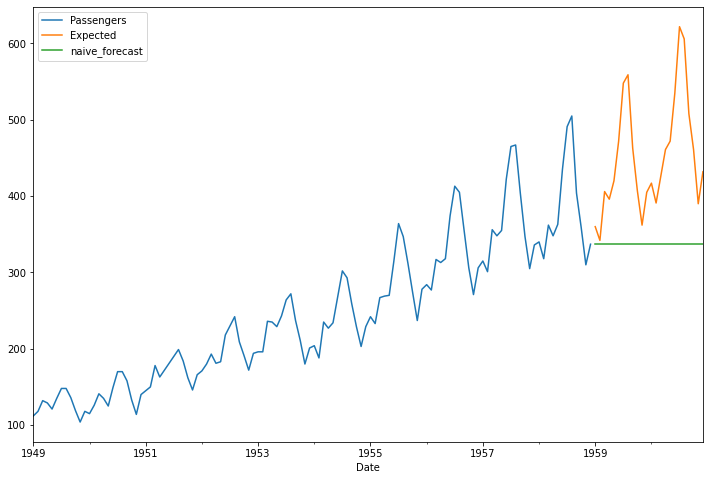

In [525]:
#Plot and compare the predictions
fig, ax = plt.subplots()
df_train.plot(ax=ax)
df_pred[['Expected', 'naive_forecast']].plot(ax=ax)
plt.show()

In [526]:
model_name='naive_forecast'
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast


**Global average**
- Get the average of all the training data 
- Can capture trend

In [527]:
#Mean of the training data set
y_pred = df_train[y].mean()
df_pred['global_average'] = y_pred

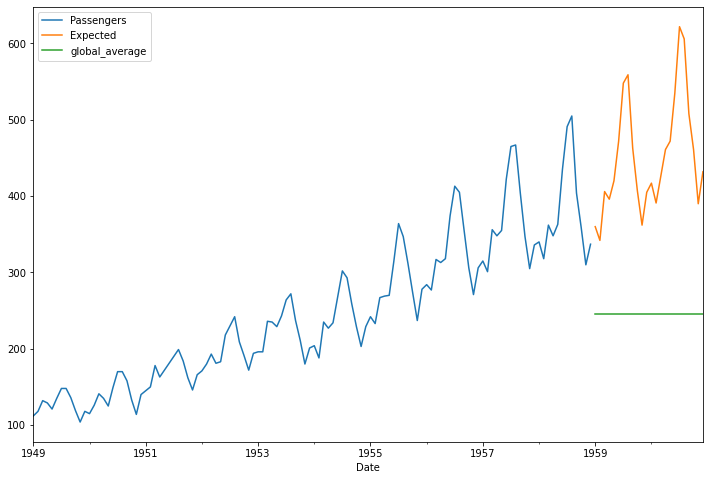

In [528]:
#Plot and compare the predictions
fig, ax = plt.subplots()
df_train.plot(ax=ax)
df_pred[['Expected', 'global_average']].plot(ax=ax)
plt.show()

In [529]:
model_name='global_average'
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average


**Moving windowed average**
- Get the average of the recent window of training data 
- can capture trend
- parameter: window size / order of moving average

In [530]:
#Compute the averge of the last N points,
# N is the size of the window
# Ideally should be one cycle?
#For N=6
y_pred = df_train[y][-6:].mean()
df_pred['window_average_6'] = y_pred

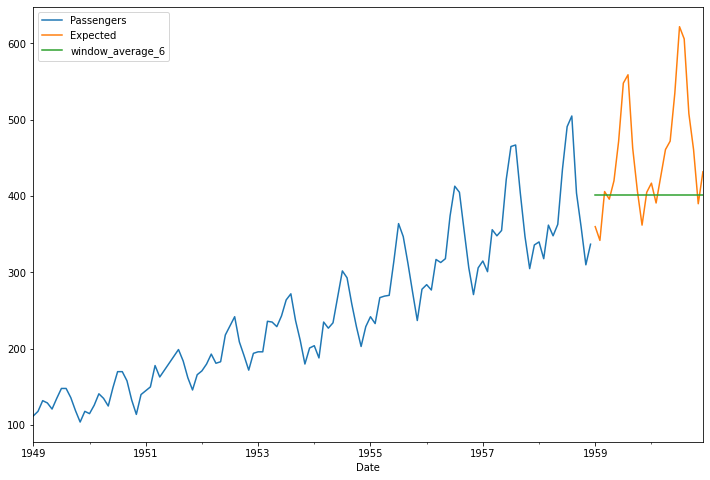

In [531]:
#Plot and compare the predictions
fig, ax = plt.subplots()
df_train.plot(ax=ax)
df_pred[['Expected', 'window_average_6']].plot(ax=ax)
plt.show()

In [532]:
model_name='window_average_6'
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6


In [533]:
#For differnt window sizes
for i in [3,6,9,12]:
    y_pred = df_train[y][-i:].mean()
    y_pred = np.array([y_pred]*df_pred.shape[0])
    rmse = get_rmse(df_pred['Expected'], y_pred)
    mape = get_mape(df_pred['Expected'], y_pred)
    print(i, rmse, mape)

3 138.91 24.01
6 90.64 12.97
9 94.39 13.58
12 103.33 15.54


**First order exponential Smoothing** 
- Can capture level
- Current_data + smoothed version of previous data
- As we go into future, the influence of previous data decreases exponentially
- This ensures recent data has more influence on forecast than the past data
- Parameter: lambda - allows a control of smoothing, and the removal of noise
- ypred_t = l\*y_t + (1-l)\*ypred_(t-1)

In [534]:
_model = SimpleExpSmoothing(df_train[y])
model = _model.fit(optimized=True) #Letting the tool decide the optimal smoothing parameter for us
model.params
y_pred = model.forecast(df_test.shape[0]).values
df_pred['Simple Exponential Smoothing'] = y_pred

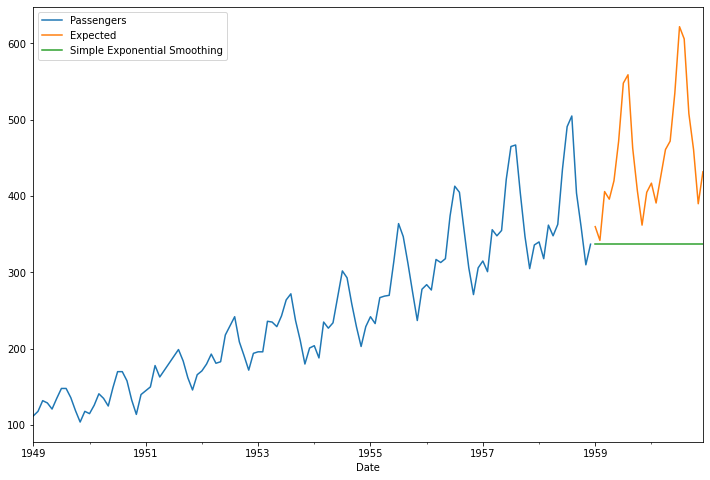

In [535]:
fig, ax = plt.subplots()
df_train.plot(label='train', ax=ax)
df_pred[['Expected', 'Simple Exponential Smoothing']].plot(ax=ax)
plt.show()

In [536]:
model_name='Simple Exponential Smoothing'
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing


In [537]:
#This model has a parameter 
print("Level parameter", model.params['smoothing_level'])

Level parameter 0.9999999850988388


In [538]:
#For different smoothing levels
for i in np.linspace(0.1,1.0,10):
    _model = SimpleExpSmoothing(df_train[y])
    model = _model.fit(smoothing_level=i)
    model.params
    y_pred = model.forecast(df_test.shape[0]).values
    rmse = get_rmse(df_pred['Expected'], y_pred)
    mape = get_mape(df_pred['Expected'], y_pred)
    print(round(i, 2), rmse, mape)

0.1 108.76 16.73
0.2 107.65 16.49
0.3 114.19 17.87
0.4 122.57 19.82
0.5 130.25 21.74
0.6 135.83 23.18
0.7 138.98 24.03
0.8 139.98 24.3
0.9 139.33 24.12
1.0 137.51 23.63


**Holt's exponential smoothing**
- can capture level and trend

In [539]:
#ExponentialSmoothing() with seasonal=None is same as Holt()
#Trend needs to be enabled for it to optimise the trend parameter
#Seasonal is none for this method
_model = ExponentialSmoothing(df_train[y], trend='additive', seasonal=None)
model = _model.fit(optimized=True)
y_pred = model.forecast(df_test.shape[0])
df_pred["Holt's exponential smoothing"] = y_pred

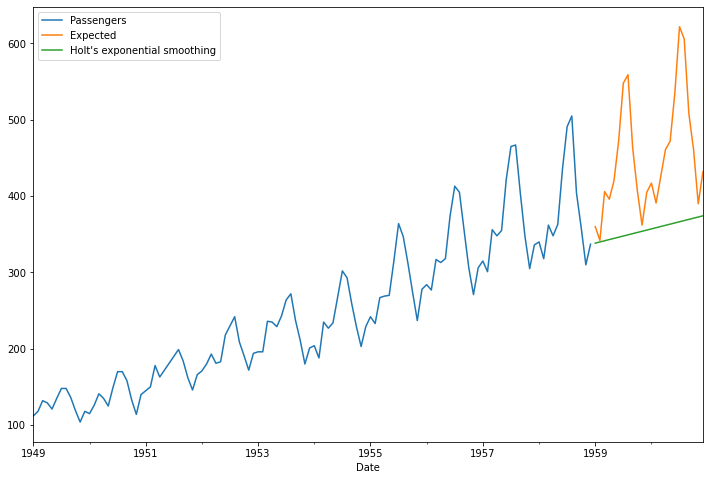

In [540]:
fig, ax = plt.subplots()
df_train.plot(label='train', ax=ax)
df_pred[['Expected', "Holt's exponential smoothing"]].plot(ax=ax)
plt.show()

In [541]:
print("Level parameter ", model.params['smoothing_trend'])
print("Trend parameter ", model.params['smoothing_level'])

Level parameter  0.0009054319520518981
Trend parameter  0.9934512310535834


In [542]:
model="Holt's exponential smoothing"
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model], model))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing
4,19.42,119.66,Holt's exponential smoothing


**Holt-Winter's exponential smoothing**
- can capture level, trend and seasonality

In [543]:
#seasonal and trend needs to be provided for the method to identify the parameters
_model = ExponentialSmoothing(df_train[y], seasonal='mul', trend='add')
model = _model.fit(optimized=True)
y_pred = model.forecast(df_test.shape[0])
df_pred['HW exponential smoothing'] = y_pred

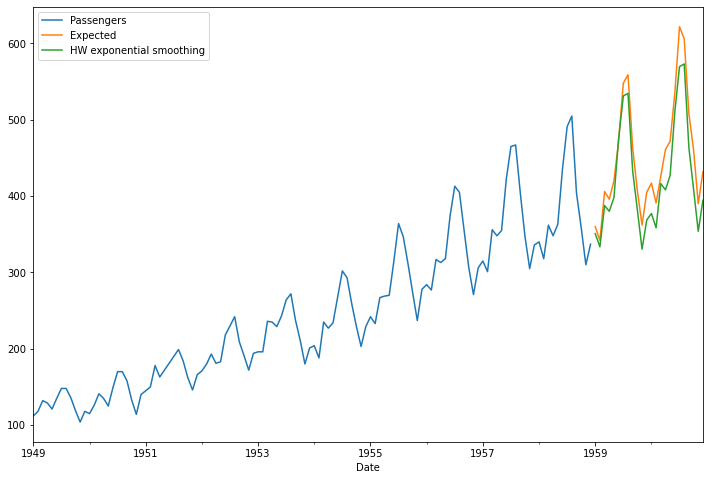

In [544]:
fig, ax = plt.subplots()
df_train.plot(label='train', ax=ax)
df_pred[['Expected', "HW exponential smoothing"]].plot(ax=ax)
plt.show()

In [545]:
print("Level parameter ", model.params['smoothing_trend'])
print("Trend parameter ", model.params['smoothing_level'])
print("Seasonal parameter ", model.params['smoothing_seasonal'])

Level parameter  1.8844605281966404e-09
Trend parameter  0.3655890122229721
Seasonal parameter  0.6344109872708108


In [546]:
model="HW exponential smoothing"
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model], model))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing
4,19.42,119.66,Holt's exponential smoothing
5,6.45,32.45,HW exponential smoothing


# Auto Regression Models

- Auto -> Use self data
- Regression -> Create a regression model
- Use the past data to predict the future values

## Assumptions of AR models

1. Stationarity
2. Auto Correlation


**Stationarity**
   - Mean, variance and co-variance of different intervals does not change over time
   - Constant Mean means - no identifiable trends, roughly horizontal
   - Constant variance means - the amplitude of the cycles do not change over time
   - Constant co-variance means - the frequency of cycles do not change over time
   - Present and future observations will follow the same statistical properties
   - **Definition:** If {y_t} is stationary series, then for for all s, the distribution of (y_t, y_t+1, ... y_t+s) does not depend on t
   - The ACF of stationary data drops to 0 very quickly, whereas for a non-stationary data, it decreases slowly
   
    
*Strict Stationarity*

*Weak Stationarity*

**Examples of stationary time series**

White noise
- Statistical properites ?

**Examples of non-stationary time series**

Random walk
 - Long periods of apparent trends up or down
 - sudden and unpredictable changes in direction
 - Stock tickers?

### Stationarity

**Stationarity Tests**

1. KPSS tests

**Null Hypothesis** : Series is stationary (Criteria: p-value > 0.05)

**Alterntative Hypothesis** : Series is not stationary ()


In [547]:
result = kpss(df_ml[y], store=True)
print("H0: ", result[-1].H0 )
print("p-value: ", result[1])

H0:  The series is level stationary
p-value:  0.01


p-value is not sufficient enough to support the null hypothesis that the series is not stationary

2. ADF tests

**Null hypothesis**: Series is not stationary (Criteria: p-value >= 0.05)

**Alternative hypothesis**: Series is stationary 

In [548]:
result = adfuller(df_ml[y], store=True)
print("H0: ", result[-1].H0 )
print("p-value: ", result[1])
print("ADF test statistic: ", result[0])
print("Critical values to compare ADF test statistic : ", result[-2])

H0:  The coefficient on the lagged level equals 1 - unit root
p-value:  0.9930195647605924
ADF test statistic:  0.8946087940823844
Critical values to compare ADF test statistic :  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


1. p-value is high enough to support the null hypothesis that the series is not stationary
2. ADF statistic : more negative it is, the stronger is the rejetion of null hypothesis.
3. Compare the critical values to check the confidence levels of the Alternate hypothesis. Here it's ~1% (1-0.99)

----
`Questions`

1. Which is one preferred (if there is one) and why?
2. Can I get 2 contradictory answers from both the tests?
3. How complex is the math to understand?
4. What are the other parameters returned in the results?
5. Why is it called as a unit root test
----

## Conversion from non stationary to stationary time series
Both needs to be applied.

1. Differencing: 
   - change between current observation and past
   - used to remove the trend from time series. 
   - Will make the mean constant (Helps in stabilising the mean)
   - First order -> y'_t = y_t - y_(t-1) ... eliminates the linear trend
   - Second order -> y''_t =  (y'_t - y'(t-1)) = (y_t - y_(t-1)) - (y_(t-1) - y_(t-2)) ... eliminates the quadratic trend
   - If first order differencing did not help in making the series stationary, need to go for second order
   - In practice, we don't generally go beyond second order
   - Higher order also leads to loss of data
   - **Seasonal differencing**
       - Difference between an observation and the corresponding observation from the previous season (week, month, year ...)
       - y'_t = y_t - y_(t-m)     ; m-> no. of seasons
   - seasonal differencing is usually stronger than regular
   - both can be applied, order is commutative, but applying seasonal first will let us know if we need to proceed further
   - It is important to ensure that the result of differencing is interpretable
   - Backshift notation can be used to show differencing; where symbo B^n is used to show the shifts, with n denoting the lag order
       - B^2*y (1-shift); 
       - B^2*y (2-shift) ; 
       - (1-B)y (first order difference) 
       - (1-B)^2 (second order difference) 
       - (1-B^2) (second differene) --> y_t - y_(t-2)
   
   
2. Transformation
   - Remove the seasonality
   - Make the variance constant
   - Makes the variance constant over time (helps to statbilise variance)
   - Take a log, square, root transform ...
   
   
3. Aggregation
4. Smoothing
5. Decomposition


### Differencing

In [549]:
#Doing a transformation first and then differencing is a better way 
#boxcox transform of the data
xt = boxcox(df_ml[y], lmbda=0)  #Why was lambda chosen as (0)?
base = pd.Series(xt)
differencing_example = pd.DataFrame({'base': base, 
                  'shift1': base.shift(1),
                  'shift2': base.shift(2)})

**1st Order differencing**

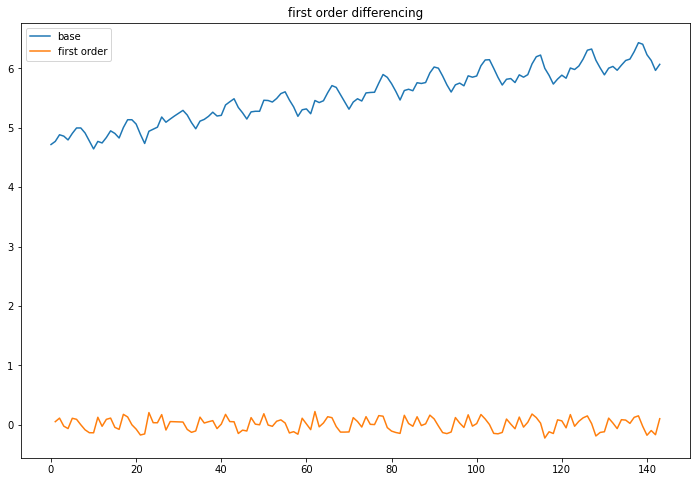

In [550]:
differencing_example['base'].plot()
(differencing_example['base'] - differencing_example['shift1']).plot(title='first order differencing', label='first order')
plt.legend()
plt.show()

**2nd Order differencing**

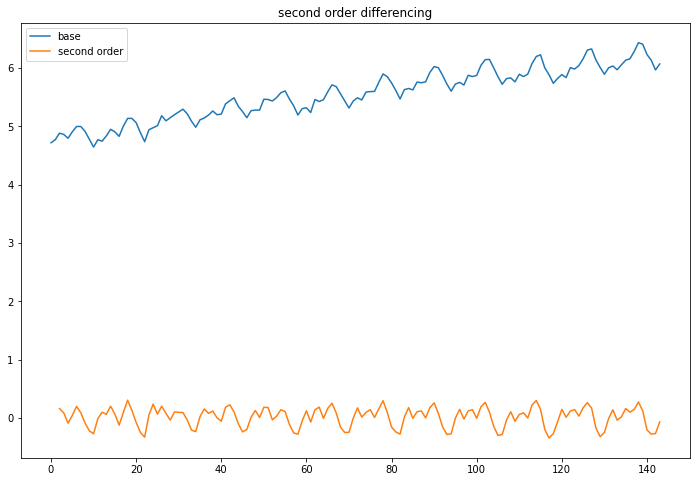

In [551]:
differencing_example['base'].plot()
(differencing_example['base'] - differencing_example['shift2']).plot(title='second order differencing', label='second order')
plt.legend()
plt.show()

**Higher order leads to loss of information**

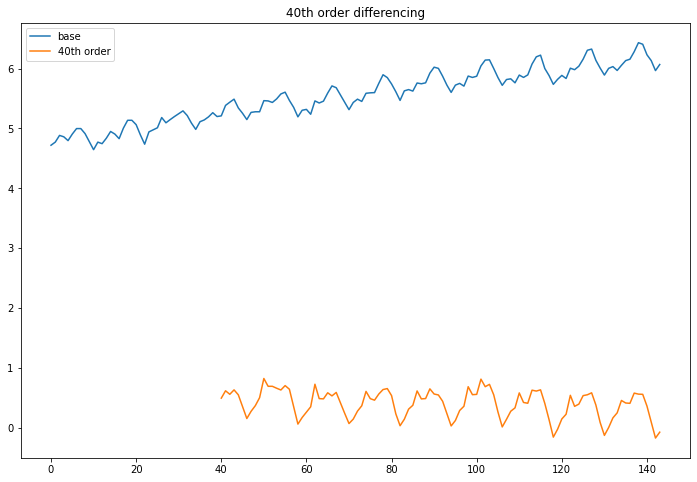

In [552]:
differencing_example['base'].plot()
(differencing_example['base'] - differencing_example['base'].shift(40)).plot(title='40th order differencing', label='40th order')
plt.legend()
plt.show()

### Transformation

**Box-Cox Transformation**
  - Family of power transforms
  - Choice of lambda (-5,+5) (CrossValidate) (?)

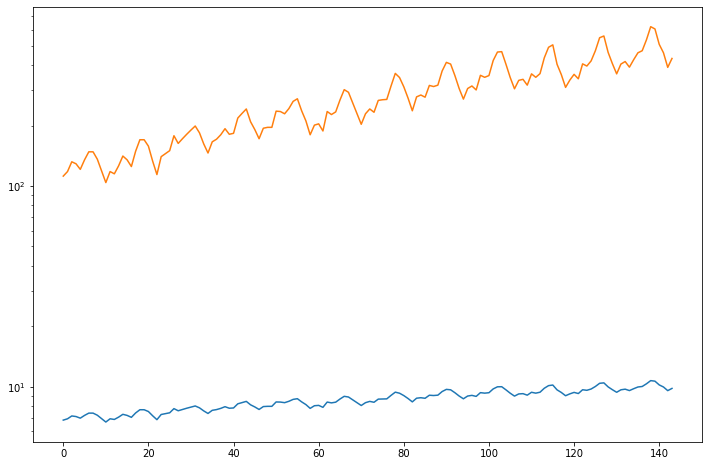

In [553]:
xt, _ = boxcox(df_ml[y])
plt.plot(xt)
plt.plot(df_ml[y].values)
ax = plt.gca()
ax.set_yscale('log')
plt.show()

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

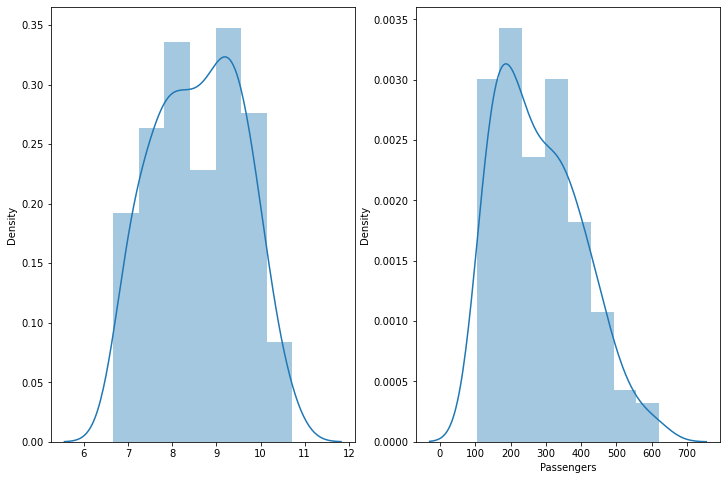

In [554]:
fig, axs = plt.subplots(ncols=2)
sns.distplot(xt, ax=axs[0])
sns.distplot(df_ml[y], ax=axs[1])

**Transform and difference**

In [555]:
#Transform
xt = boxcox(df_ml[y], lmbda=0)
#Store the transform -- needed for some modes which only prefer transform
y_boxcox = pd.Series(xt)
y_boxcox.index = df_ml.index
#Difference
y_boxcox_diff = pd.Series(pd.Series(xt) - pd.Series(xt).shift())
#Get the index back
y_boxcox_diff.index=df_ml.index
#Remove nan values, otherwise it might mess up models and other functions
y_boxcox_diff.dropna(inplace=True)

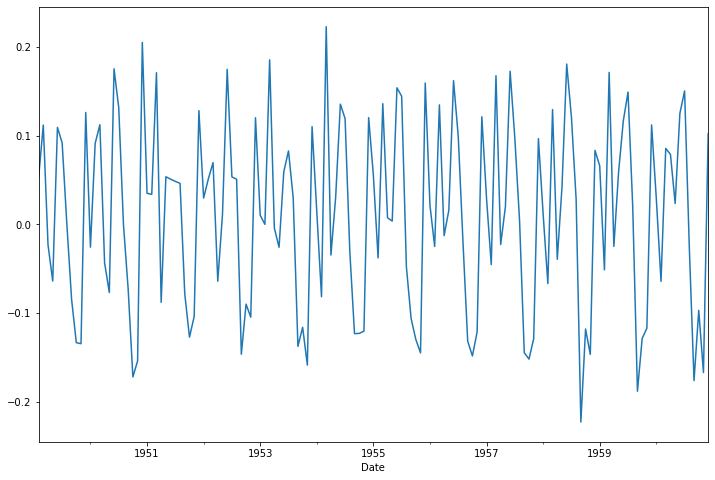

In [556]:
y_boxcox_diff.plot()
plt.show()

<AxesSubplot:xlabel='Date'>

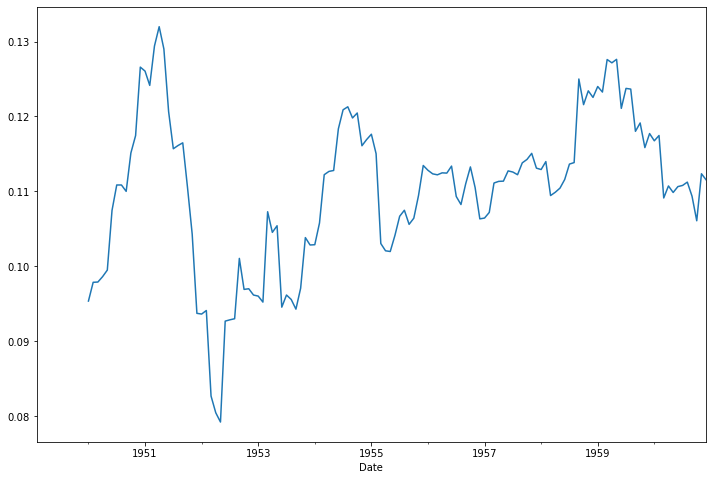

In [557]:
y_boxcox_diff.rolling(12).std().plot()

**Decompose and check for trend and seasonality change**

Multiplicative decomposition won't work for negative or 0 values


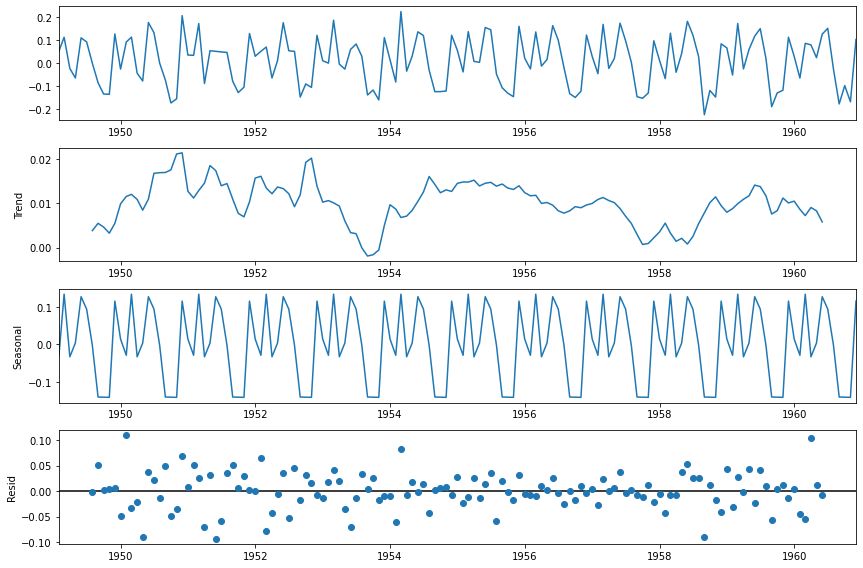

In [558]:
decomposition_trans = tsa.seasonal_decompose(y_boxcox_diff.dropna(), model='additive')
decomposition_trans.plot()
plt.show()

- trend is more or less constant and hovering around 0
- We don't see any noticeable variations in the seasonal component either

**Seasonality tests**

Checking if our approach of transform and difference has brought stationarity to the data.

**KPSS**

In [559]:
result = kpss(y_boxcox_diff, store=True)
print("H0: ", result[-1].H0 )
print("p-value: ", result[1])

H0:  The series is level stationary
p-value:  0.1


**ADF**

In [560]:
result = adfuller(y_boxcox_diff, store=True)
print("H0: ", result[-1].H0 )
print("p-value: ", result[1])
print("ADF test statistic: ", result[0])
print("Critical values to compare ADF test statistic : ", result[-2])

H0:  The coefficient on the lagged level equals 1 - unit root
p-value:  0.015326212237943804
ADF test statistic:  -3.2901138184594267
Critical values to compare ADF test statistic :  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


## ACF and PACF

**Autocorelation function**
    - Auto -> Comparing with the same variable
    - Corelation -> Lag and compare by every time unit
    - Also captures indirect relationship, i.e tn related to t(n-2) via t(n-1)
    - Change in the past can tell us about future if we can notice correlation
    - Objective would be to select the lag order to auto-corelate
    - Helps in selecting the moving average window parameter for models
    

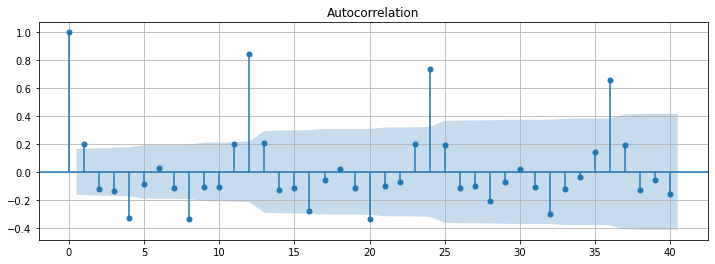

In [561]:
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(y_boxcox_diff, ax=ax, lags=40)
ax.grid()
plt.show()

**Partial AutoCorelation function**
    - Relationship that a lagged variable has with the future variable (or vice cersa)
    - Only considers direct relationship
    
    

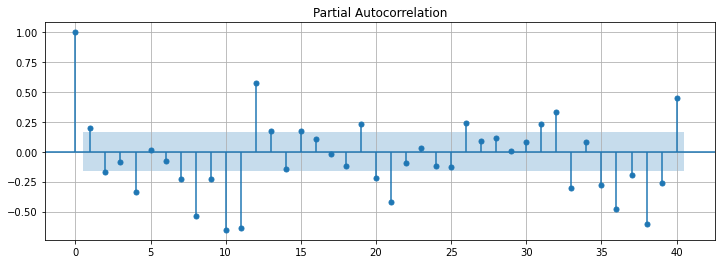

In [562]:
fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(y_boxcox_diff, ax=ax, lags=40)
ax.grid()
plt.show()

## Auto Regression Models

Assumptions: ?

1. AR (Auto Regressive) (simple)
2. MA (Moving Average)
3. ARMA (Auto Regressive Moving Average)
4. ARIMA (Auto Regressive Integrated Moving Average)
5. SARIMA (Seasonal ARIMA)
6. SARMIAX (Seasonal ARIMA eXogenous variable)


AR - Auto Regressive (Lagged observations as input) (Uses the dependent relationship between an observation and its lag   
I - integrated (differencing of the observations to make series stationary)   
MA - Moving Average (lagged errors as input)(Uses the dependent relationship between an observation and residual error of a lagged observation)  

Representation of ARIMA models  
ARIMA(p, d, q)  
p -> lag order  
d -> degree of differencing  
q -> size of moving average window

**Split transformed dataset into train and test**

1. With only transformed - Some models can perform only differencing, so only transformed data can be inputted to them (ARIMA, SARIMA, SARIMAX) 
2. With both transform and differencing done - Some models needs to have the complete stationarizing steps completed (AR, MA, ARMA)

In [563]:
print(train_test_split_index)

120


In [564]:
#Un-transformed dataset
df_train = df_ml[:train_test_split_index]
df_test = df_ml[train_test_split_index:]
print(df_train.shape)
print(df_test.shape)

(120, 1)
(24, 1)


In [565]:
#Only transform
df_train_bc = y_boxcox[:train_test_split_index]
df_test_bc = y_boxcox[train_test_split_index:]
print(df_train_bc.shape)
print(df_test_bc.shape)

(120,)
(24,)


In [566]:
#With both transform and difference
df_train_bcd = y_boxcox_diff[:train_test_split_index-1]
df_test_bcd = y_boxcox_diff[train_test_split_index-1:]
print(df_train_bcd.shape)
print(df_test_bcd.shape)

(119,)
(24,)


**AR**

- Simple model, predicts future observations as a linear combination of the past observations
- **Assumptions**: Series is stationary
- Has a hyperparameter (p) - lag order. 
- Selecting p -> Plot PACF. Select the highest value of p where the lag is higher than the significance level.
- Build the AR equation
- y_pred = w0 + w_p1\*y_(t-1) + w_p2\*y_(t-2) + ... + w_pp\*y_(t-p)
- The w and y, or weights and lags, are picked based on the lag order
- Captures trend and level
- Regress onto the auto-correlation data ?

- y_t = c + w0*y(t-1) + e
    - if w0 = 0 ... y is white noise
    - if w0 = 1 and c = 0 ... y is random walk
    - if w0 = 1 and c !=0 ... y is random walk with drift
    - if w0 < 0 ... y_t oscillates between -ve and +ve values
    
- preferred when ?

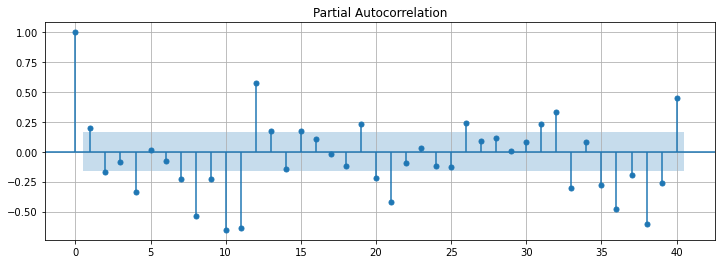

In [567]:
#Determining parameter p
fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(y_boxcox_diff, ax=ax, lags=40)
ax.grid()
plt.show()

In [568]:
abs(pd.Series(pacf(y_boxcox_diff))).sort_values(ascending=False)[:5]

0     1.000000
10    0.653750
11    0.635759
38    0.600285
12    0.577562
dtype: float64

In [569]:
p=1
i=0
q=0
_model = ARIMA(df_train_bcd, order=(p,i,q))
model = _model.fit()
model.params

const      0.009477
ar.L1.y    0.183116
dtype: float64

In [570]:
#Make the prediction
#Why are we predicting the entire set?
y_pred = model.predict(y_boxcox_diff.index.min(), y_boxcox_diff.index.max()) 
#Because we differenced the data earlier to make it stationary, It is necessary to get all the predictions 
# before the test data starts, so that the results can be shifted appropriately
#Since we used the diffferenced data, use cumulative sum to reverse the effect
y_pred = y_pred.cumsum()
#Since the first data point was dropped, it needs to be included in the cumsum
y_pred = y_pred.add(y_boxcox[0])
#Reversing the trasnformation
y_pred = np.exp(y_pred)
#Why the reverse path?
#Since the data was transofrmed, use inverse transform of boxcox (?)
df_pred['AR'] = y_pred[train_test_split_index-1:]

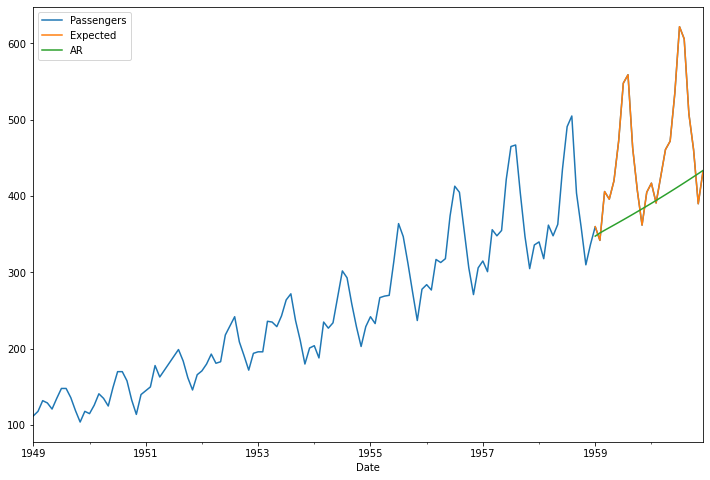

In [571]:
fig, ax = plt.subplots()
df_ml.plot(label='train', ax=ax)
df_pred[['Expected', "AR"]].plot(ax=ax)
plt.show()

In [572]:
model_name="AR"
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing
4,19.42,119.66,Holt's exponential smoothing
5,6.45,32.45,HW exponential smoothing
6,13.77,93.39,AR


**MA**
- What gets better?
    - AR ignored correlated noise structures in the time series ?
- **Assumptions**: Series is stationary
- Considers past forecast errors to make future predictions
- Has a hyperparameter (q) - window size
- Plot ACF. Select the highest (-ve or +ve) point after which the correlation dies (or is below the significance value), this is the "q" parameter
- The window size determines the past error values that needs to be considered to make the future predictions
- y_pred = mean + phi_1 * err_(t-1) + phi_2 * err_(t-2) + ...phi_q * err_(t-q)
- Captures trend and level 

In [573]:
p=0
i=0
q=1
#Use the training set
_model = ARIMA(df_train_bcd, order=(p, i, q))
model = _model.fit()
print(model.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


In [574]:
#Make the prediction
#Because we differenced the data earlier to make it stationary, It is necessary to get all the predictions 
# before the test data starts, so that the results can be shifted appropriately
y_pred = model.predict(y_boxcox_diff.index.min(), y_boxcox_diff.index.max()) 
#Since we used the diffferenced data, use cumulative sum to reverse the effect
y_pred = y_pred.cumsum()
#Since the first data point was dropped, it needs to be included in the cumsum
y_pred = y_pred.add(y_boxcox[0])
#Reversing the trasnformation
y_pred = np.exp(y_pred)
#Why the reverse path?
#Since the data was transofrmed, use inverse transform of boxcox (?)
df_pred['MA'] = y_pred[train_test_split_index-1:]

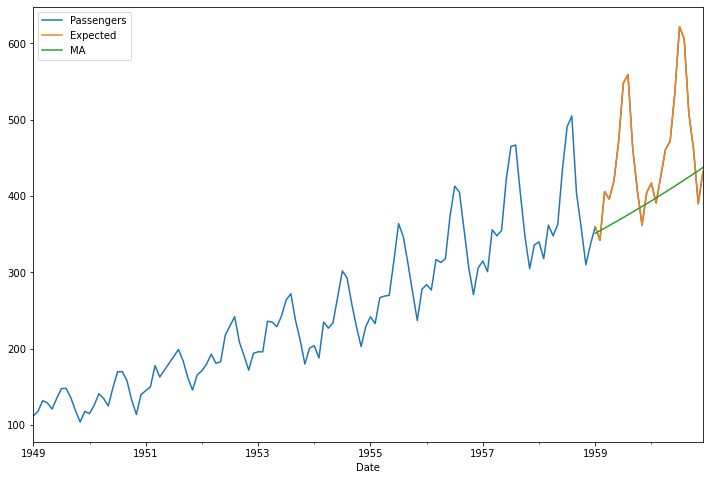

In [575]:
fig, ax = plt.subplots()
df_ml.plot(label='train', ax=ax)
df_pred[['Expected', "MA"]].plot(ax=ax)
plt.show()

In [576]:
model_name="MA"
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing
4,19.42,119.66,Holt's exponential smoothing
5,6.45,32.45,HW exponential smoothing
6,13.77,93.39,AR
7,13.39,91.21,MA


**ARMA**
- What gets better?
- **Assumptions**: Series is stationary
- hyperparameter
    - Find p from AR
    - Find q from MA
- Combine both to build the model
- Captures trend and level

In [577]:
p=1
i=0
q=1
_model = ARIMA(df_train_bcd, order=(p, i, q))
model = _model.fit()
print(model.params)
print(model.summary())

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(1, 1)   Log Likelihood                 104.725
Method:                       css-mle   S.D. of innovations              0.100
Date:                Mon, 25 Jan 2021   AIC                           -201.451
Time:                        23:43:20   BIC                           -190.334
Sample:                    02-01-1949   HQIC                          -196.937
                         - 12-01-1958                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.011      0.890      0.374      -0.012       0.031
ar.L1.y       -0.5271      0.141     -3.738      0.000  

In [578]:
#make the predictions on the whole set, this is because we need to rebuild the series
y_pred = model.predict(y_boxcox_diff.index.min(), y_boxcox_diff.index.max(),)
#cumulative sum to reverse first difference
y_pred = y_pred.cumsum()
#Add the first data, since it was bumped off after the first difference
y_pred = y_pred.add(y_boxcox[0])
#inverse transform
y_pred = np.exp(y_pred)
df_pred['ARMA'] = y_pred[train_test_split_index-1:]

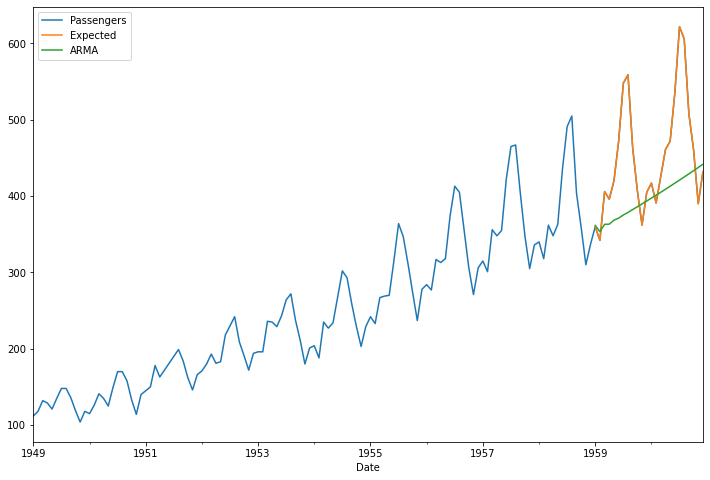

In [579]:
fig, ax = plt.subplots()
df_ml.plot(label='train', ax=ax)
df_pred[['Expected', "ARMA"]].plot(ax=ax)
plt.show()

In [580]:
model_name="ARMA"
perf_l.append(evaluate_perf(df_pred['Expected'], df_pred[model_name], model_name))
pd.DataFrame(perf_l)

,MAPE,RMSE,Model
0,23.63,137.51,naive_forecast
1,44.28,219.69,global_average
2,12.97,90.64,window_average_6
3,23.63,137.51,Simple Exponential Smoothing
4,19.42,119.66,Holt's exponential smoothing
5,6.45,32.45,HW exponential smoothing
6,13.77,93.39,AR
7,13.39,91.21,MA
8,12.89,88.88,ARMA


**ARIMA**
- What gets better?
- Input need not be differenced, the model handles it internally
- **Assumptions**: Series is stationary w.r.t constant variance
- Stationary w.r.t constant mean is handled in the model
- Parameters
    - p from AR
    - q from MA
    - i - Degree of differencing to make the series stationary
- It models the differenced series as a linear regression of past values (like AR) and errors on past predictions (like MA)
- Captures trend and level

In [581]:
df_train_bc.shape

(120,)

In [583]:
df_train_bc.tail()

Date
1958-08-01    6.224558
1958-09-01    6.001415
1958-10-01    5.883322
1958-11-01    5.736572
1958-12-01    5.820083
dtype: float64

In [592]:
p=1
i=1
q=1
_model = ARIMA(df_train_bc, order=(p, i, q))
model = _model.fit()
print(model.params)
print(model.summary())

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 104.725
Method:                       css-mle   S.D. of innovations              0.100
Date:                Tue, 26 Jan 2021   AIC                           -201.451
Time:                        08:48:37   BIC                           -190.334
Sample:                    02-01-1949   HQIC                          -196.937
                         - 12-01-1958                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.011      0.890      0.374      -0.012       0.031
ar.L1.D.y     -0.5271      0.141     -3.738      0

In [593]:
#make the predictions on the test set, this is because we did not pass in a differenced series
# So we don't have to rebuild it again
y_pred = model.predict(y_boxcox_diff.index.min(), y_boxcox_diff.index.max())
#cumulative sum to reverse first difference
y_pred = y_pred.cumsum()
#Add the first data, since it was bumped off after the first difference
y_pred = y_pred.add(y_boxcox[0])
#inverse transform
y_pred = np.exp(y_pred)
# Make sure to use the y_pred entirely for performance evaluate, as it contains predictions for the test
#  dataset only
df_pred['ARIMA'] = y_pred

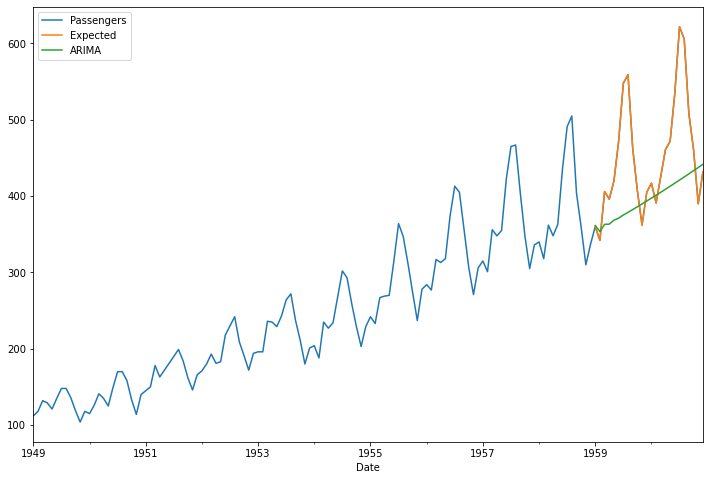

In [597]:
fig, ax = plt.subplots()
df_ml.plot(label='train', ax=ax)
df_pred[['Expected', "ARIMA"]].plot(ax=ax)
plt.show()

**SARIMA**
- Assumptions: Stationary time series w.r.t to mean
- Parameters: 
    - Non seasional (p, d, q) and seasonal (m, P, D, Q)
    - m - no of steps in  a season
    - P - Seasonal auto regressive order
    - Q - Seasonal Moving Avearage
    - D - 
- Regular differencing and Seasonal differencing
- Input need not be differenced as the model has the parameter to do it internally

In [ ]:
plot

In [596]:
p=1
i=1
q=1
_model = ARIMA(df_train_bc, order=(p, i, q))
model = _model.fit()
print(model.params)
print(model.summary())

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 104.725
Method:                       css-mle   S.D. of innovations              0.100
Date:                Tue, 26 Jan 2021   AIC                           -201.451
Time:                        08:48:58   BIC                           -190.334
Sample:                    02-01-1949   HQIC                          -196.937
                         - 12-01-1958                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.011      0.890      0.374      -0.012       0.031
ar.L1.D.y     -0.5271      0.141     -3.738      0

**SARMIAX**

1. Exogenous variable is also included into the model building.
2. We need to have future values to predict future of y

`Questions`
1. Why do some models have box_cox_diff transformed as input and some have box_cox transformed as input?
2. Industry preference is SARIMA and Holt's triple exponential method; and SARIMAX when there is exogenous variable
3. Do we use the exogenous variable in SARMIAX to check it's influence or after we have verified it's influence?

# Summary

1. Time series has 3 components Level, Trend, Seasonality to be considered when choosing a model
2. Since this is a regression problem, whatever metrics are applicable for measuring error in regression model are applicable here
    - However r_squared and adjusted r_squared are not valid onces as it considers how much a model captures variance compared with a model which predicts the mean of the data.
    - Generally RMSE and MAPE are used
    - Others ...

# Links

1. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
2. https://robjhyndman.com/uwafiles/6-Stationarity-Transformations-Differencing.pdf
    - BoxCox transformation
    - Stationarity and non-stationarity
3. https://raw.githubusercontent.com/robjhyndman/ETC3550Slides/fable/9-arima.pdf
    - ARIMA et al models
4. http://people.cs.pitt.edu/~milos/courses/cs3750/lectures/class16.pdf
    - Stationarity, AR family models.
5. https://otexts.com/fpp3/